In [1]:
#for loading data
import pandas as pd
import json

#for llm
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel

#logging
import pickle

#similarity
import regex as re
from sentence_transformers import SentenceTransformer

#visualization
#plot matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load data

In [2]:
job_statements = pd.read_excel("datasets/task_statements.xlsx")
job_statements.columns = job_statements.columns.str.lower()
job_statements = job_statements.drop(labels=["incumbents responding","date","domain source"], axis=1).rename(columns={"o*net-soc code":"code", "task type":"type", "task id": "id"})
job_statements = job_statements[~job_statements["type"].str.contains("Supplemental", case=False, na=True)]
job_statements["ind"] = job_statements["code"].str[:2]
job_statements

,code,title,id,task,type,ind
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,11
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,11
2,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,11
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,11
4,11-1011.00,Chief Executives,8834,Prepare or present reports concerning activiti...,Core,11
...,...,...,...,...,...,...
18781,53-7121.00,"Tank Car, Truck, and Ship Loaders",12793,Observe positions of cars passing loading spou...,Core,53
18782,53-7121.00,"Tank Car, Truck, and Ship Loaders",12795,Monitor product movement to and from storage t...,Core,53
18783,53-7121.00,"Tank Car, Truck, and Ship Loaders",12794,"Operate ship loading and unloading equipment, ...",Core,53
18784,53-7121.00,"Tank Car, Truck, and Ship Loaders",12796,Record operating data such as products and qua...,Core,53


In [55]:
#extract occu list from job statement list 
occupations = job_statements.drop(labels=["id", "task", "type"], axis=1)
occupations = occupations.drop_duplicates()
sampled_occupation = occupations.groupby('ind', group_keys=False).sample(frac=0.05, random_state=1) #43 samples
test_sample = sampled_occupation.sample(5, random_state= 2)
test_sample_list = [test_sample.iloc[x]["title"] for x in range(len(test_sample))]
test_sample_list


['Telephone Operators',
 'Forest and Conservation Technicians',
 'Elementary School Teachers, Except Special Education',
 'Human Resources Managers',
 'Wind Energy Development Managers']

### set up matching function

In [4]:
def get_des (title):
    task_list = list(job_statements.query("title == @title")["task"])
    return task_list

In [5]:
def match(gen, ref):
    sim_model = SentenceTransformer("all-mpnet-base-v2", similarity_fn_name="cosine")

    # Compute embeddings for both lists
    embeddings_gen = sim_model.encode(gen)
    embeddings_ref = sim_model.encode(ref)

    # Compute cosine similarities
    similarities = float(sim_model.similarity(embeddings_gen, embeddings_ref))
    return similarities

In [6]:
#plot graph
def plot(similarities):
    x_label = [x+1 for x in range(len(similarities))]
    y_label = [chr(num + 96) for num in x_label]
    plt.figure(figsize=(12, 12))
    sns.heatmap(similarities, annot=True, fmt=".3f", cmap="crest", xticklabels=x_label, yticklabels=y_label)
    plt.title("Sentence Cosine Similarity for "+ test_occ)
    plt.xlabel("O*NET Data")
    plt.ylabel("Generated Sentence")
    plt.savefig("results/"+test_occ+".png")
    plt.show()
    return plt

In [7]:
#pre process text
def preProcessText(text=list):
	processed = []
	for doc in text:
		doc = re.sub(r"\\n", "", doc)
		doc = re.sub(r"\W", " ", doc) #remove non words char
		doc = re.sub(r"\d"," ", doc) #remove digits char
		doc = re.sub(r'\s+[a-z]\s+', "", doc) # remove a single char
		doc = re.sub(r'^[a-z]\s+', "", doc) #remove a single character at the start of a document
		doc = re.sub(r'\s+', " ", doc)  #replace an extra space with a single space
		doc = re.sub(r'^\s', "", doc) # remove space at the start of a doc
		doc = re.sub(r'\s$', "", doc) # remove space at the end of a document
		processed.append(doc.lower())
	return processed

In [8]:
# parse response
def parse_response(response):
    try:
        parsed = json.loads(response["statements"])
        return parsed
    except:
        try:
            parsed = response["statements"]
            return parsed
        except:
            return "invalid"

In [51]:
def task_gen(title,model):
    class job_statement(BaseModel):
        role: str
        statements: list[str]


    #initialize model
    # model= ChatOllama(model="llama3.1", temperature=1), format= 'json')
    model= model

    task = "generate "+str(len(get_des(title)))+" task statements that a {name} would perform at work."

    prompt_template = ChatPromptTemplate([
        # ("system", "your role is a {name}. Respond like a {name}."),
        ("human","{input}")
        ]
    )
    structured_llm = model.with_structured_output(schema=job_statement.model_json_schema())

    prompt = prompt_template.invoke({"name": title, "input": task})
    response = structured_llm.invoke(prompt)

    return response
    

In [34]:
def add_record(occupation, ref, gen, df):
    new_row = pd.DataFrame({'role': occupation, 'ref_statements': [ref], "gen_statements":[gen]})
    df = pd.concat([df, new_row], ignore_index=True)
    return df

### packaging things for repeated excution

In [48]:
model = ChatOllama(model="llama3.1", temperature=1)

In [47]:
data = ["role", "ref_statements", "gen_statements"]
record = pd.DataFrame(columns=data)
record

,role,ref_statements,gen_statements


In [52]:
for occu in test_sample_list:
    reference_statements = get_des(occu)
    generated_statements = task_gen(occu, model)
    record = add_record(occu, reference_statements, generated_statements, record)

record


,role,ref_statements,gen_statements
0,Telephone Operators,"[Observe signal lights on switchboards, and di...","{'role': 'Telephone Operator', 'statements': '..."
1,Forest and Conservation Technicians,[Thin and space trees and control weeds and un...,"{'role': 'Forest and Conservation Technician',..."
2,"Elementary School Teachers, Except Special Edu...","[Instruct students individually and in groups,...","{'role': 'Elementary School Teachers, Except S..."
3,Human Resources Managers,[Serve as a link between management and employ...,"{'role': 'Human Resources Manager', 'statement..."
4,Wind Energy Development Managers,"[Coordinate or direct development, energy asse...","{'role': 'Wind Energy Development Manager', 's..."
5,Telephone Operators,"[Observe signal lights on switchboards, and di...","{'role': '{name}', 'statements': '[""Attend mor..."
6,Forest and Conservation Technicians,[Thin and space trees and control weeds and un...,"{'role': '{name}', 'statements': '[""Design use..."
7,"Elementary School Teachers, Except Special Edu...","[Instruct students individually and in groups,...","{'role': '{name}', 'statements': '[""Task 1"",""T..."
8,Human Resources Managers,[Serve as a link between management and employ...,"{'role': '{name}', 'statements': '[""data entry..."
9,Wind Energy Development Managers,"[Coordinate or direct development, energy asse...","{'role': '{name}', 'statements': '[""Meet with ..."


In [53]:
similarity_score = []
for x in range(len(record)):
    gen_clean = "".join(preProcessText(parse_response(record["gen_statements"].iloc[x])))
    ref_clean = "".join(preProcessText(record["ref_statements"].iloc[x]))
    similarity_score.append(match(gen_clean, ref_clean))

similarity_score

[0.769441545009613,
 0.6515114903450012,
 0.7625613808631897,
 0.8361252546310425,
 0.8547928929328918,
 0.5699836015701294,
 0.2603439390659332,
 0.1919810175895691,
 0.3310691714286804,
 0.5504266023635864]

In [58]:
max(similarity_score)

0.8547928929328918

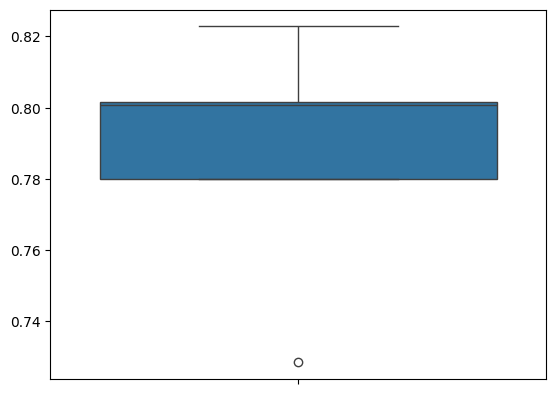

In [ ]:
bplot = sns.boxplot(sim_l)

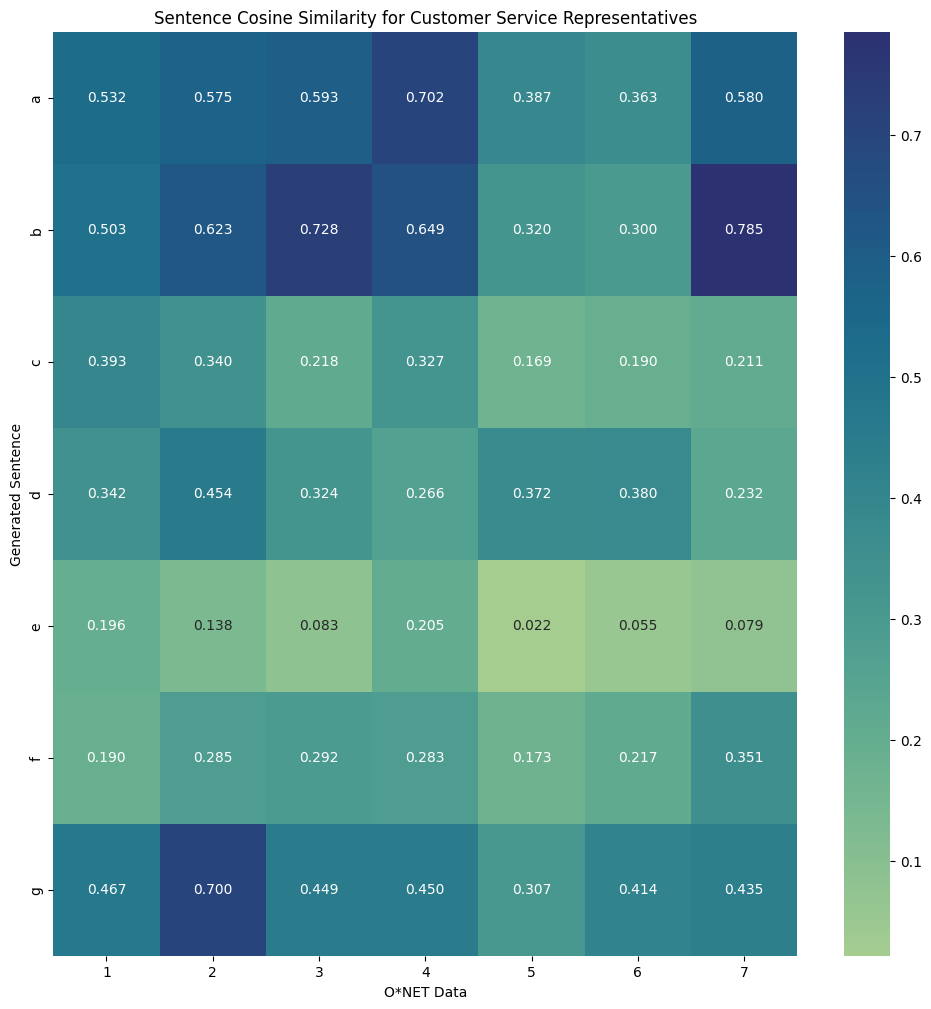

['Respond to customer inquiries', 'Resolve customer complaints', 'Provide product information', 'Process transactions', 'Answer frequently asked questions', 'Escalate complex issues', 'Document customer interactions']


In [ ]:
plot_processed(gen_des, test_occ)

In [ ]:
s1 = ["".join(preProcessText(get_des(test_occ)))]
s2 = ["".join(preProcessText(get_des(test_occ))).replace("and", "").replace("or", "")]
match(s2, s1)

tensor([[0.9331]])